In [ ]:
import pandas as pd
from google.colab import files
uploaded=files.upload()

Saving telecom_safe_features.csv to telecom_safe_features.csv


In [ ]:
df=pd.read_csv("telecom_safe_features.csv")

In [ ]:
# --- Step 1. Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


print("✅ Data Loaded Successfully!")
print("Shape:", df.shape)
print(df['churn'].value_counts())

✅ Data Loaded Successfully!
Shape: (42122, 22)
churn
0    30771
1    11351
Name: count, dtype: int64


In [ ]:
print(df.columns)

Index(['year', 'month', 'circle', 'type_of_connection', 'service_provider',
       'value', 'date', 'value_lag_1', 'value_lag_3', 'value_lag_6',
       'value_lag_12', 'circle_type', 'is_wireless',
       'operator_geographic_diversity', 'market_size_category', 'market_share',
       'market_rank', 'share_gap_leader', 'relative_performance', 'circle_hhi',
       'subscriber_change', 'churn'],
      dtype='object')


In [ ]:
# --- Step 3. Feature/Target Split ---
target = 'churn'
drop_cols = ['date', 'subscriber_change','circle']  # not to leak trend info
features = [col for col in df.columns if col not in drop_cols + [target]]

X = df[features].copy()
y = df[target].copy()

# --- Step 4. Encode categorical variables ---
cat_cols = X.select_dtypes(include=['object', 'category']).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

print("Categorical Columns Encoded:", list(cat_cols))

Categorical Columns Encoded: ['type_of_connection', 'service_provider', 'circle_type']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


🚀 Fold 1 ------------------------------

🚀 Fold 2 ------------------------------

🚀 Fold 3 ------------------------------

🚀 Fold 4 ------------------------------

🚀 Fold 5 ------------------------------

📊 Random Forest Average Results (5-fold TimeSeriesSplit)
Accuracy            : 0.9679
F1-score            : 0.9158
ROC-AUC             : 0.9685
Precision           : 0.9158
Recall              : 0.9164
Precision@Top10%    : 0.9536


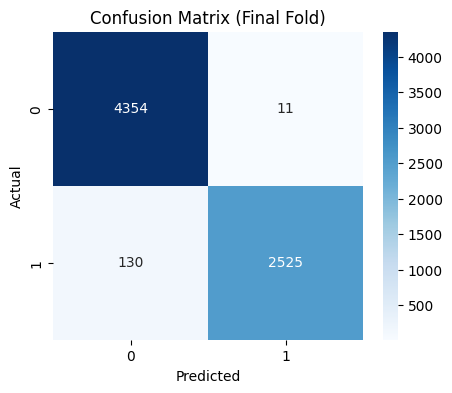

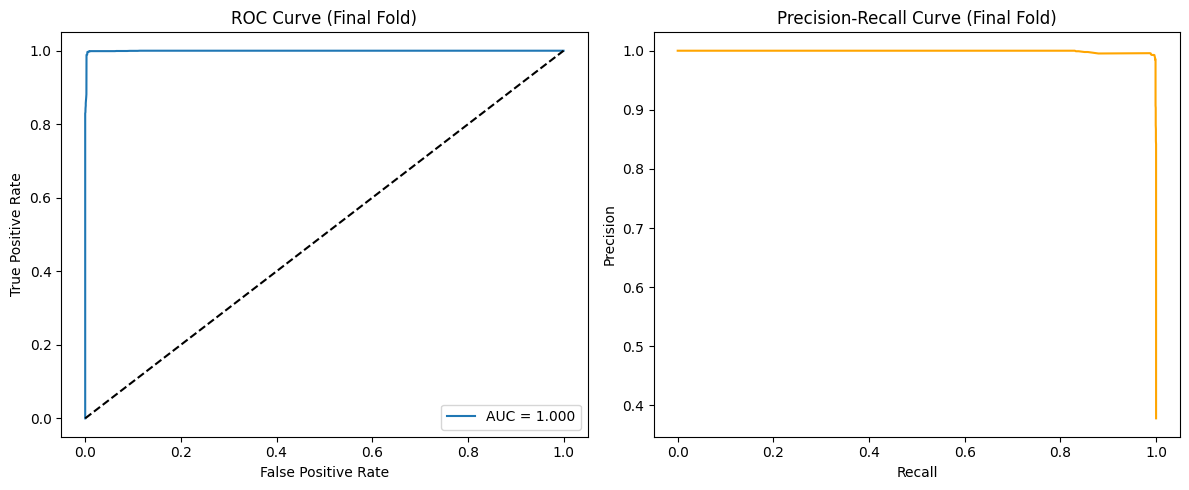

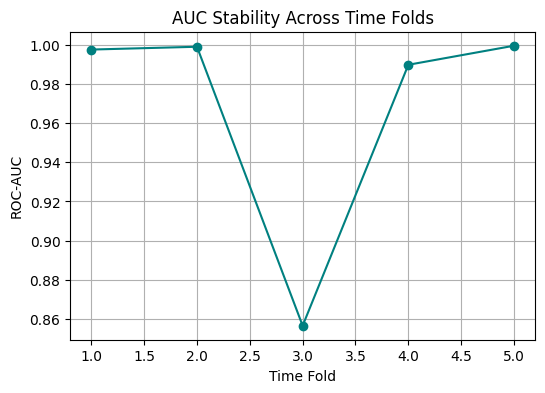


❌ Misclassified Samples in Final Fold: 141
Example Misclassified Rows:


,Actual,Predicted,Pred_Prob,year,month,type_of_connection,service_provider,value
35846,1,0,0.255,2011,9,0,36,392233.0
35985,1,0,0.285,2012,1,0,36,422962.0
36016,1,0,0.435,2014,7,1,36,90.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve, precision_recall_curve, auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_acc, rf_f1, rf_auc, rf_precision, rf_recall, rf_prec_top10 = [], [], [], [], [], []
fold_aucs, cm_final, final_misclassified = [], None, pd.DataFrame()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n🚀 Fold {fold} ------------------------------")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    # --- Core Metrics ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    fold_aucs.append(auc_val)

    # --- Precision@Top10% ---
    top_decile = int(len(y_prob) * 0.1)
    top_idx = np.argsort(y_prob)[-top_decile:]
    prec_top10 = precision_score(y_test.iloc[top_idx], y_pred[top_idx])

    rf_acc.append(acc)
    rf_f1.append(f1)
    rf_auc.append(auc_val)
    rf_precision.append(prec)
    rf_recall.append(rec)
    rf_prec_top10.append(prec_top10)

    # Store confusion matrix & misclassified from last fold
    if fold == 5:
        cm_final = confusion_matrix(y_test, y_pred)
        misclassified = X_test.copy()
        misclassified["Actual"] = y_test
        misclassified["Predicted"] = y_pred
        misclassified["Pred_Prob"] = y_prob
        final_misclassified = misclassified[misclassified["Actual"] != misclassified["Predicted"]]
        y_test_final, y_prob_final = y_test, y_prob

# --- Average Results Summary ---
results_dict = {
    "Accuracy": np.mean(rf_acc),
    "F1-score": np.mean(rf_f1),
    "ROC-AUC": np.mean(rf_auc),
    "Precision": np.mean(rf_precision),
    "Recall": np.mean(rf_recall),
    "Precision@Top10%": np.mean(rf_prec_top10)
}

print("\n📊 Random Forest Average Results (5-fold TimeSeriesSplit)")
for k, v in results_dict.items():
    print(f"{k:20}: {v:.4f}")

# --- Confusion Matrix (Final Fold) ---
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Final Fold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC & Precision-Recall Curves ---
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
prec, rec, _ = precision_recall_curve(y_test_final, y_prob_final)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_prob_final):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Final Fold)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='orange')
plt.title("Precision-Recall Curve (Final Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# --- AUC Stability Across Time Splits ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(fold_aucs)+1), fold_aucs, marker='o', color='teal')
plt.title("AUC Stability Across Time Folds")
plt.xlabel("Time Fold")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

# --- Misclassified Samples Summary ---
print(f"\n❌ Misclassified Samples in Final Fold: {len(final_misclassified)}")
print("Example Misclassified Rows:")
display(final_misclassified.head(3)[["Actual", "Predicted", "Pred_Prob"] + list(X.columns[:5])])


🚀 XGBoost - Fold 1

🚀 XGBoost - Fold 2

🚀 XGBoost - Fold 3

🚀 XGBoost - Fold 4

🚀 XGBoost - Fold 5

📊 XGBoost Average Results (5-fold TimeSeriesSplit)
Accuracy            : 0.9675
F1-score            : 0.9135
ROC-AUC             : 0.9755
Precision           : 0.9005
Recall              : 0.9275
Precision@Top10%    : 0.9963


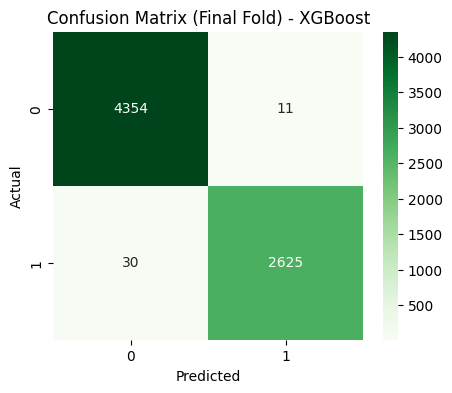

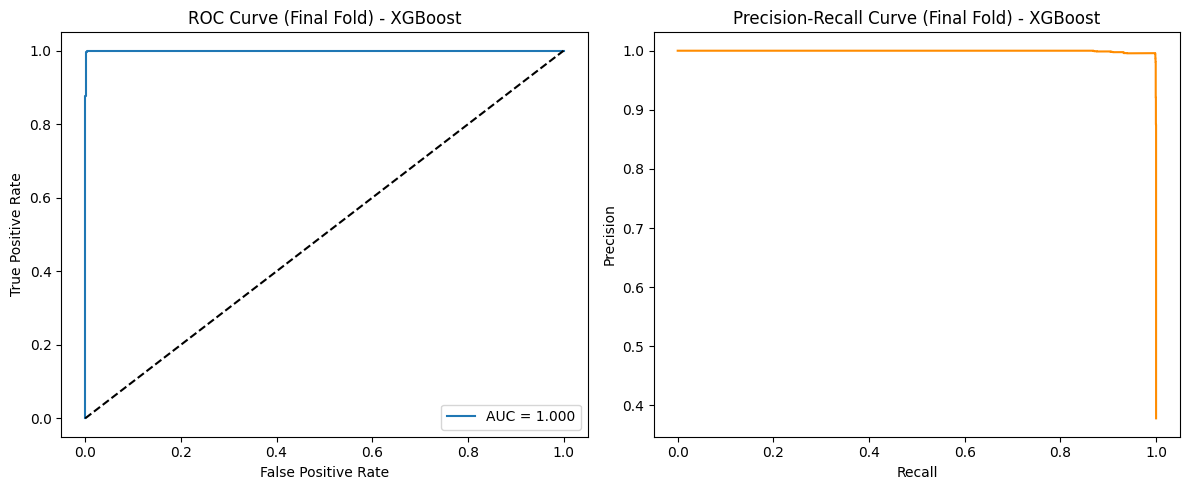

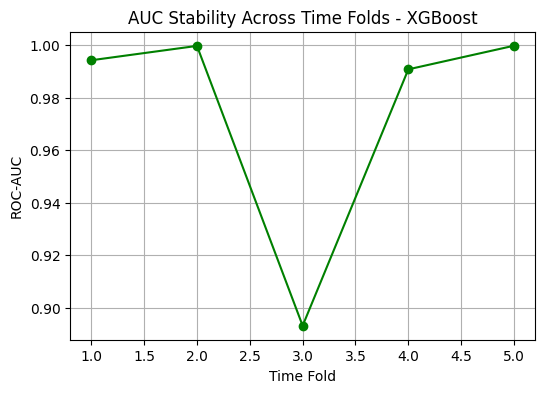


❌ Misclassified Samples in Final Fold: 41
Example Misclassified Rows:


,Actual,Predicted,Pred_Prob,year,month,type_of_connection,service_provider,value
35846,1,0,0.286281,2011,9,0,36,392233.0
35985,1,0,0.360207,2012,1,0,36,422962.0
36016,1,0,0.112783,2014,7,1,36,90.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ===============================================================
# ⚙️ XGBoost with TimeSeriesSplit + Business Metrics
# ===============================================================

xgb_acc, xgb_f1, xgb_auc, xgb_precision, xgb_recall, xgb_prec_top10 = [], [], [], [], [], []
fold_aucs, cm_final, final_misclassified = [], None, pd.DataFrame()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n🚀 XGBoost - Fold {fold}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- Model ---
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # --- Core Metrics ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    fold_aucs.append(auc_val)

    # --- Precision@Top10% ---
    top_decile = int(len(y_prob) * 0.1)
    top_idx = np.argsort(y_prob)[-top_decile:]
    prec_top10 = precision_score(y_test.iloc[top_idx], y_pred[top_idx])

    xgb_acc.append(acc)
    xgb_f1.append(f1)
    xgb_auc.append(auc_val)
    xgb_precision.append(prec)
    xgb_recall.append(rec)
    xgb_prec_top10.append(prec_top10)

    # --- Store for final fold analysis ---
    if fold == 5:
        cm_final = confusion_matrix(y_test, y_pred)
        misclassified = X_test.copy()
        misclassified["Actual"] = y_test
        misclassified["Predicted"] = y_pred
        misclassified["Pred_Prob"] = y_prob
        final_misclassified = misclassified[misclassified["Actual"] != misclassified["Predicted"]]
        y_test_final, y_prob_final = y_test, y_prob

# --- Average Results Summary ---
results_dict = {
    "Accuracy": np.mean(xgb_acc),
    "F1-score": np.mean(xgb_f1),
    "ROC-AUC": np.mean(xgb_auc),
    "Precision": np.mean(xgb_precision),
    "Recall": np.mean(xgb_recall),
    "Precision@Top10%": np.mean(xgb_prec_top10)
}

print("\n📊 XGBoost Average Results (5-fold TimeSeriesSplit)")
for k, v in results_dict.items():
    print(f"{k:20}: {v:.4f}")

# --- Confusion Matrix (Final Fold) ---
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Final Fold) - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC & Precision-Recall Curves ---
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
prec, rec, _ = precision_recall_curve(y_test_final, y_prob_final)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_prob_final):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Final Fold) - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkorange')
plt.title("Precision-Recall Curve (Final Fold) - XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# --- AUC Stability Across Time Splits ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(fold_aucs) + 1), fold_aucs, marker='o', color='green')
plt.title("AUC Stability Across Time Folds - XGBoost")
plt.xlabel("Time Fold")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

# --- Misclassified Samples Summary ---
print(f"\n❌ Misclassified Samples in Final Fold: {len(final_misclassified)}")
print("Example Misclassified Rows:")
display(final_misclassified.head(3)[["Actual", "Predicted", "Pred_Prob"] + list(X.columns[:5])])


🚀 LightGBM - Fold 1
[LightGBM] [Info] Number of positive: 2362, number of negative: 4660
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data points in the train set: 7022, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

🚀 LightGBM - Fold 2
[LightGBM] [Info] Number of positive: 5197, number of negative: 8845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 14042, number of

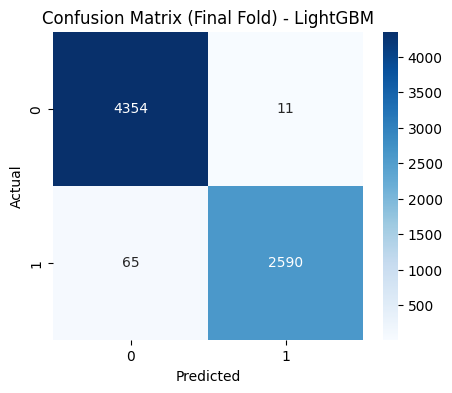

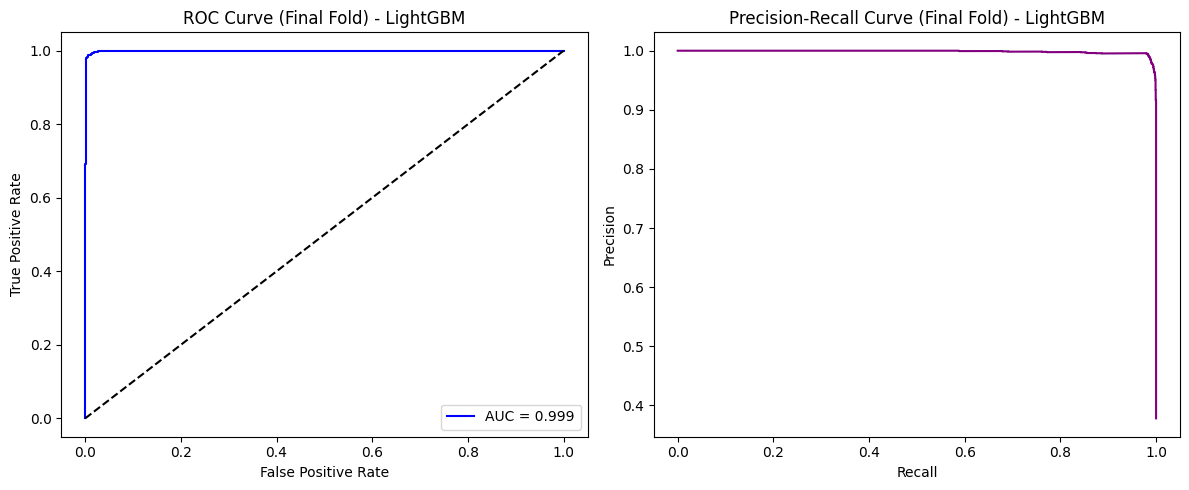

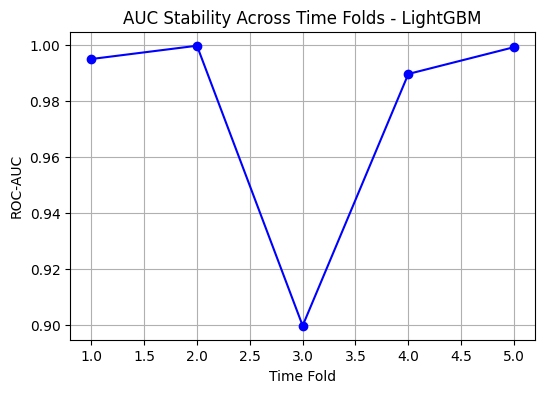


❌ Misclassified Samples in Final Fold: 76
Example Misclassified Rows:


,Actual,Predicted,Pred_Prob,year,month,type_of_connection,service_provider,value
35985,1,0,0.268600,2012,1,0,36,422962.0
36016,1,0,0.030605,2014,7,1,36,90.0
36018,1,0,0.472118,2014,8,1,36,90.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ===============================================================
# 💡 LightGBM with TimeSeriesSplit + Business Metrics
# ===============================================================

lgb_acc, lgb_f1, lgb_auc, lgb_precision, lgb_recall, lgb_prec_top10 = [], [], [], [], [], []
fold_aucs, cm_final, final_misclassified = [], None, pd.DataFrame()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n🚀 LightGBM - Fold {fold}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- Model ---
    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # --- Core Metrics ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    fold_aucs.append(auc_val)

    # --- Precision@Top10% ---
    top_decile = int(len(y_prob) * 0.1)
    top_idx = np.argsort(y_prob)[-top_decile:]
    prec_top10 = precision_score(y_test.iloc[top_idx], y_pred[top_idx])

    lgb_acc.append(acc)
    lgb_f1.append(f1)
    lgb_auc.append(auc_val)
    lgb_precision.append(prec)
    lgb_recall.append(rec)
    lgb_prec_top10.append(prec_top10)

    # --- Store for final fold analysis ---
    if fold == 5:
        cm_final = confusion_matrix(y_test, y_pred)
        misclassified = X_test.copy()
        misclassified["Actual"] = y_test
        misclassified["Predicted"] = y_pred
        misclassified["Pred_Prob"] = y_prob
        final_misclassified = misclassified[misclassified["Actual"] != misclassified["Predicted"]]
        y_test_final, y_prob_final = y_test, y_prob

# --- Average Results Summary ---
results_dict = {
    "Accuracy": np.mean(lgb_acc),
    "F1-score": np.mean(lgb_f1),
    "ROC-AUC": np.mean(lgb_auc),
    "Precision": np.mean(lgb_precision),
    "Recall": np.mean(lgb_recall),
    "Precision@Top10%": np.mean(lgb_prec_top10)
}

print("\n📊 LightGBM Average Results (5-fold TimeSeriesSplit)")
for k, v in results_dict.items():
    print(f"{k:20}: {v:.4f}")

# --- Confusion Matrix (Final Fold) ---
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Final Fold) - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC & Precision-Recall Curves ---
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
prec, rec, _ = precision_recall_curve(y_test_final, y_prob_final)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_prob_final):.3f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Final Fold) - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='purple')
plt.title("Precision-Recall Curve (Final Fold) - LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# --- AUC Stability Across Time Splits ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(fold_aucs) + 1), fold_aucs, marker='o', color='blue')
plt.title("AUC Stability Across Time Folds - LightGBM")
plt.xlabel("Time Fold")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

# --- Misclassified Samples Summary ---
print(f"\n❌ Misclassified Samples in Final Fold: {len(final_misclassified)}")
print("Example Misclassified Rows:")
display(final_misclassified.head(3)[["Actual", "Predicted", "Pred_Prob"] + list(X.columns[:5])])

In [ ]:
!pip install catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00



🚀 CatBoost - Fold 1

🚀 CatBoost - Fold 2

🚀 CatBoost - Fold 3

🚀 CatBoost - Fold 4

🚀 CatBoost - Fold 5

📊 CatBoost Average Results (5-fold TimeSeriesSplit)
Accuracy            : 0.9673
F1-score            : 0.9160
ROC-AUC             : 0.9708
Precision           : 0.9127
Recall              : 0.9199
Precision@Top10%    : 0.9536


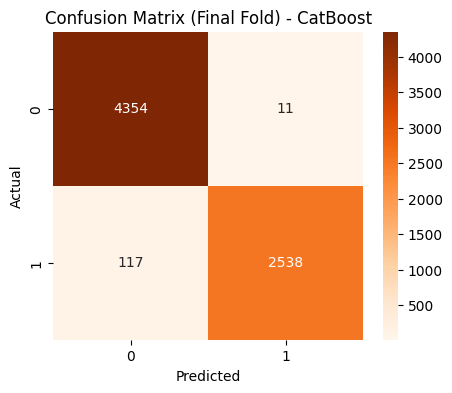

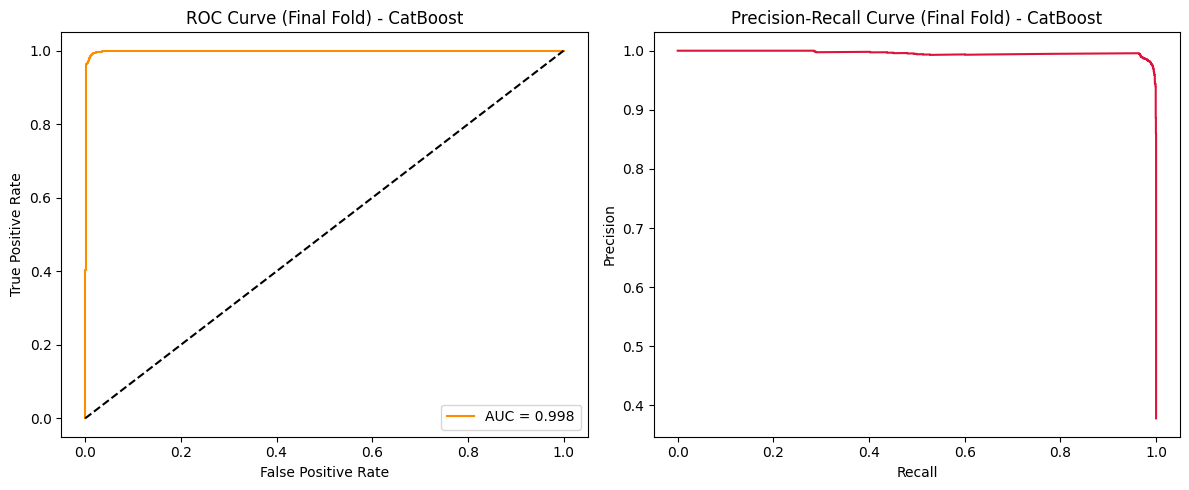

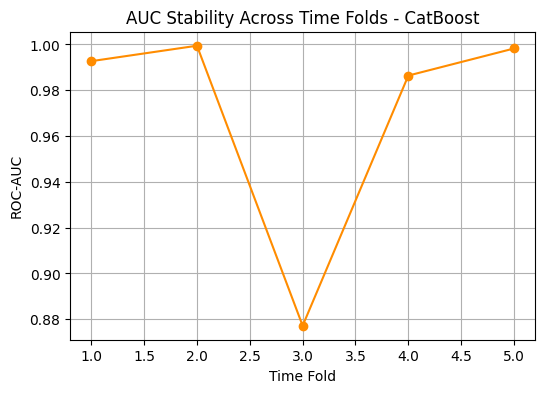


❌ Misclassified Samples in Final Fold: 128
Example Misclassified Rows:


,Actual,Predicted,Pred_Prob,year,month,type_of_connection,service_provider,value
35846,1,0,0.232387,2011,9,0,36,392233.0
35985,1,0,0.242700,2012,1,0,36,422962.0
36016,1,0,0.067564,2014,7,1,36,90.0


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ===============================================================
# 🐱 CatBoost with TimeSeriesSplit + Business Metrics
# ===============================================================

cat_acc, cat_f1, cat_auc, cat_precision, cat_recall, cat_prec_top10 = [], [], [], [], [], []
fold_aucs, cm_final, final_misclassified = [], None, pd.DataFrame()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n🚀 CatBoost - Fold {fold}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- Model ---
    model = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=False,
        class_weights=[1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # --- Core Metrics ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    fold_aucs.append(auc_val)

    # --- Precision@Top10% ---
    top_decile = int(len(y_prob) * 0.1)
    top_idx = np.argsort(y_prob)[-top_decile:]
    prec_top10 = precision_score(y_test.iloc[top_idx], y_pred[top_idx])

    cat_acc.append(acc)
    cat_f1.append(f1)
    cat_auc.append(auc_val)
    cat_precision.append(prec)
    cat_recall.append(rec)
    cat_prec_top10.append(prec_top10)

    # --- Store for final fold analysis ---
    if fold == 5:
        cm_final = confusion_matrix(y_test, y_pred)
        misclassified = X_test.copy()
        misclassified["Actual"] = y_test
        misclassified["Predicted"] = y_pred
        misclassified["Pred_Prob"] = y_prob
        final_misclassified = misclassified[misclassified["Actual"] != misclassified["Predicted"]]
        y_test_final, y_prob_final = y_test, y_prob

# --- Average Results Summary ---
results_dict = {
    "Accuracy": np.mean(cat_acc),
    "F1-score": np.mean(cat_f1),
    "ROC-AUC": np.mean(cat_auc),
    "Precision": np.mean(cat_precision),
    "Recall": np.mean(cat_recall),
    "Precision@Top10%": np.mean(cat_prec_top10)
}

print("\n📊 CatBoost Average Results (5-fold TimeSeriesSplit)")
for k, v in results_dict.items():
    print(f"{k:20}: {v:.4f}")

# --- Confusion Matrix (Final Fold) ---
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix (Final Fold) - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC & Precision-Recall Curves ---
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
prec, rec, _ = precision_recall_curve(y_test_final, y_prob_final)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_prob_final):.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Final Fold) - CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='crimson')
plt.title("Precision-Recall Curve (Final Fold) - CatBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# --- AUC Stability Across Time Splits ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(fold_aucs) + 1), fold_aucs, marker='o', color='darkorange')
plt.title("AUC Stability Across Time Folds - CatBoost")
plt.xlabel("Time Fold")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

# --- Misclassified Samples Summary ---
print(f"\n❌ Misclassified Samples in Final Fold: {len(final_misclassified)}")
print("Example Misclassified Rows:")
display(final_misclassified.head(3)[['Actual', 'Predicted', 'Pred_Prob'] + list(X.columns[:5])])


🚀 ANN - Fold 1
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🚀 ANN - Fold 2
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🚀 ANN - Fold 3
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🚀 ANN - Fold 4
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🚀 ANN - Fold 5
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 ANN Average Results (5-fold TimeSeriesSplit)
Accuracy            : 0.8988
F1-score            : 0.8080
ROC-AUC             : 0.9171
Precision           : 0.8124
Recall              : 0.8236
Precision@Top10%    : 0.8100


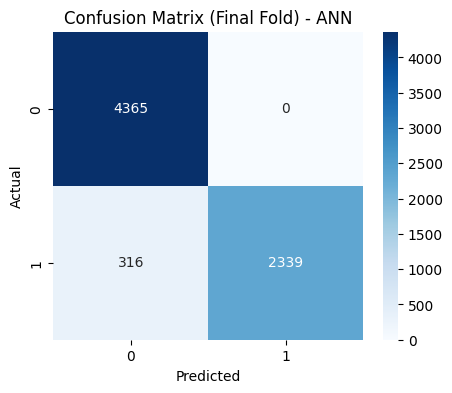

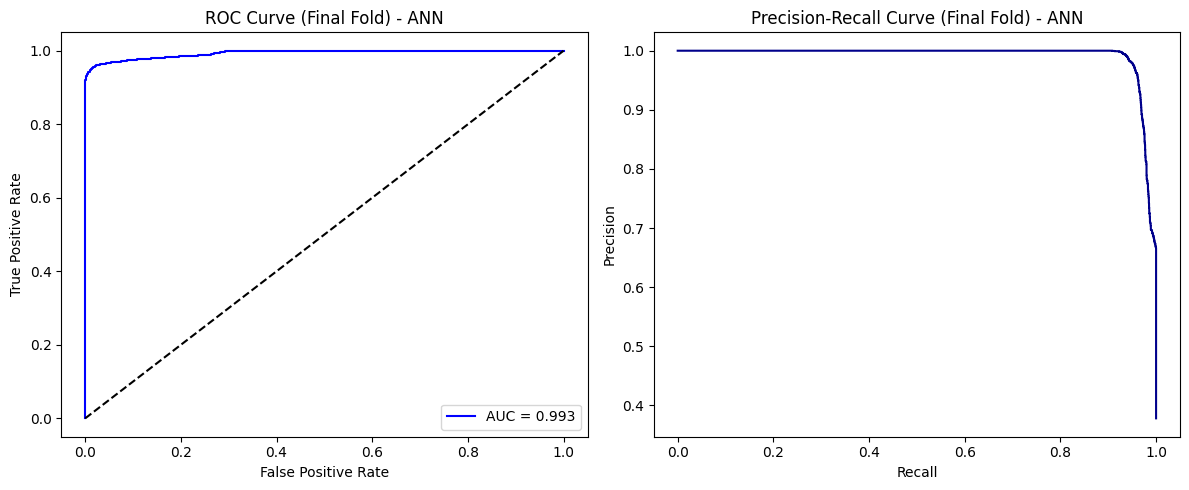

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ===============================================================
# 🧠 Artificial Neural Network (ANN) with TimeSeriesSplit + Business Metrics
# ===============================================================

ann_acc, ann_f1, ann_auc, ann_precision, ann_recall, ann_prec_top10 = [], [], [], [], [], []
fold_aucs, cm_final, final_misclassified = [], None, pd.DataFrame()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n🚀 ANN - Fold {fold}")

    # --- Split Data ---
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- Handle NaNs ---
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # --- Scale Data ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- ANN Architecture ---
    ann = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    ann.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    # --- Train Model ---
    ann.fit(X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=20, batch_size=64, verbose=0, callbacks=[early_stop])

    # --- Predictions ---
    y_prob = ann.predict(X_test_scaled).ravel()
    y_prob = np.nan_to_num(y_prob, nan=0.0)
    y_pred = (y_prob > 0.5).astype(int)

    # --- Metrics ---
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    fold_aucs.append(auc_val)

    # --- Precision@Top10% ---
    top_decile = int(len(y_prob) * 0.1)
    top_idx = np.argsort(y_prob)[-top_decile:]
    prec_top10 = precision_score(y_test.iloc[top_idx], y_pred[top_idx])

    ann_acc.append(acc)
    ann_f1.append(f1)
    ann_auc.append(auc_val)
    ann_precision.append(prec)
    ann_recall.append(rec)
    ann_prec_top10.append(prec_top10)

    # --- Store final fold details ---
    if fold == 5:
        cm_final = confusion_matrix(y_test, y_pred)
        misclassified = X_test.copy()
        misclassified["Actual"] = y_test
        misclassified["Predicted"] = y_pred
        misclassified["Pred_Prob"] = y_prob
        final_misclassified = misclassified[misclassified["Actual"] != misclassified["Predicted"]]
        y_test_final, y_prob_final = y_test, y_prob

# ===============================================================
# 📊 Average Results Summary
# ===============================================================
results_dict = {
    "Accuracy": np.mean(ann_acc),
    "F1-score": np.mean(ann_f1),
    "ROC-AUC": np.mean(ann_auc),
    "Precision": np.mean(ann_precision),
    "Recall": np.mean(ann_recall),
    "Precision@Top10%": np.mean(ann_prec_top10)
}

print("\n📊 ANN Average Results (5-fold TimeSeriesSplit)")
for k, v in results_dict.items():
    print(f"{k:20}: {v:.4f}")

# ===============================================================
# 📉 Confusion Matrix (Final Fold)
# ===============================================================
plt.figure(figsize=(5, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Final Fold) - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# 📈 ROC & Precision-Recall Curves
# ===============================================================
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
prec, rec, _ = precision_recall_curve(y_test_final, y_prob_final)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_prob_final):.3f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Final Fold) - ANN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkblue')
plt.title("Precision-Recall Curve (Final Fold) - ANN")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

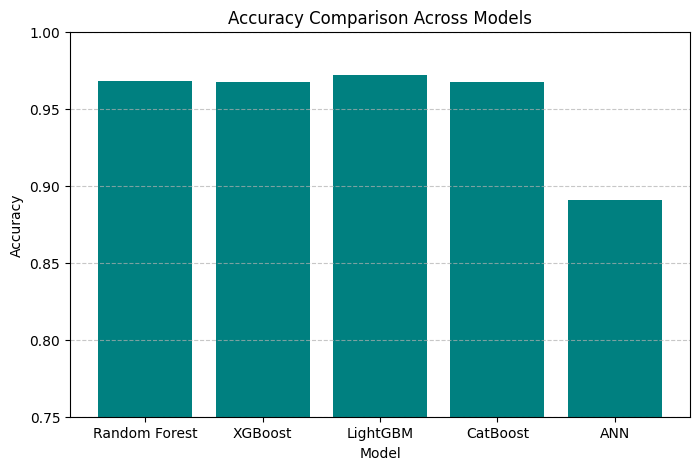

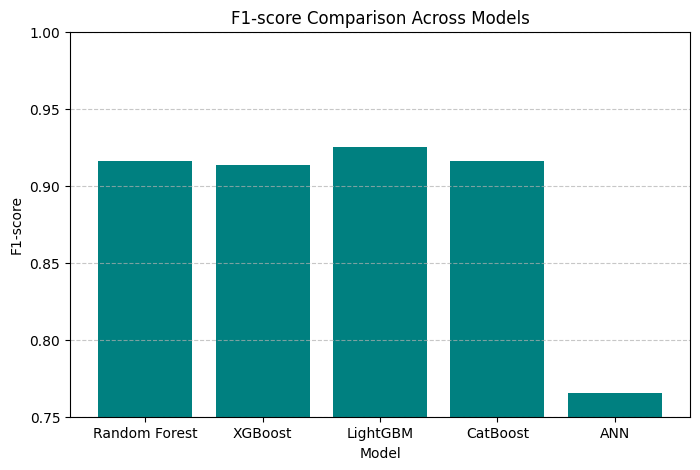

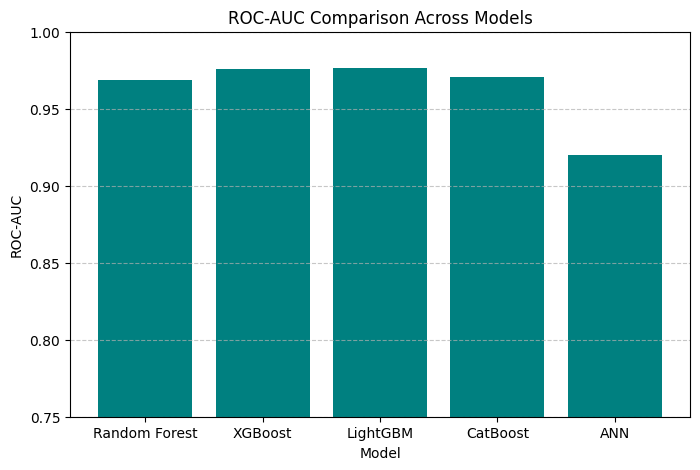

In [ ]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1-score", "ROC-AUC"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df["Model"], results_df[metric], color='teal')
    plt.title(f"{metric} Comparison Across Models")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.ylim(0.75, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

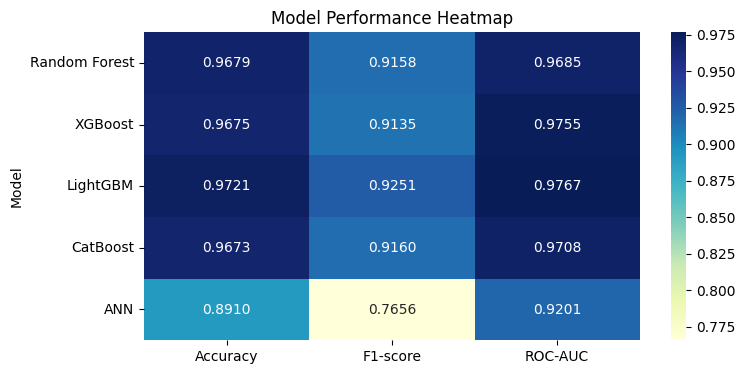

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(results_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Model Performance Heatmap")
plt.show()


--- Fold 1 ---
Accuracy: 0.9436 | F1: 0.9293 | ROC-AUC: 0.9879
              precision    recall  f1-score   support

           0     0.9452    0.9611    0.9531      4185
           1     0.9410    0.9178    0.9293      2835

    accuracy                         0.9436      7020
   macro avg     0.9431    0.9394    0.9412      7020
weighted avg     0.9435    0.9436    0.9435      7020


--- Fold 2 ---
Accuracy: 0.9642 | F1: 0.9177 | ROC-AUC: 0.9970
              precision    recall  f1-score   support

           0     0.9946    0.9603    0.9772      5592
           1     0.8630    0.9797    0.9177      1428

    accuracy                         0.9642      7020
   macro avg     0.9288    0.9700    0.9474      7020
weighted avg     0.9679    0.9642    0.9651      7020


--- Fold 3 ---
Accuracy: 0.6088 | F1: 0.2410 | ROC-AUC: 0.6274
              precision    recall  f1-score   support

           0     0.8450    0.6527    0.7365      5880
           1     0.1759    0.3825    0.2410  

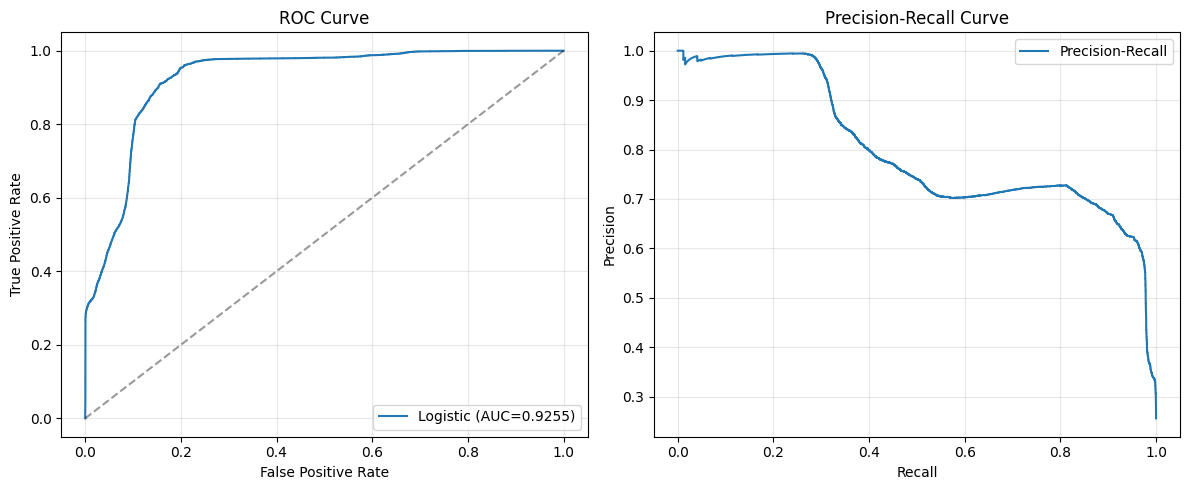


Top logistic coefficients (by absolute mean weight):
value                           -6.049450
value_lag_1                      4.893444
market_share                    -2.141422
type_of_connection               1.471634
is_wireless                     -1.471634
value_lag_3                     -1.143035
service_provider                -0.984349
relative_performance            -0.901937
value_lag_6                     -0.762454
year                            -0.739592
operator_geographic_diversity    0.543047
market_size_category            -0.243065
circle_type                      0.185460
market_rank                     -0.151480
share_gap_leader                 0.092378
month                           -0.087138
value_lag_12                     0.072287
circle_hhi                       0.007338
dtype: float64


,feature,mean_coef,abs_mean_coef
0,value,-6.049450,6.049450
1,value_lag_1,4.893444,4.893444
2,market_share,-2.141422,2.141422
3,type_of_connection,1.471634,1.471634
4,is_wireless,-1.471634,1.471634
5,value_lag_3,-1.143035,1.143035
6,service_provider,-0.984349,0.984349
7,relative_performance,-0.901937,0.901937
8,value_lag_6,-0.762454,0.762454
9,year,-0.739592,0.739592



Per-fold metrics:


,fold,accuracy,f1,roc_auc,n_train,n_test
0,1.0,0.943590,0.929286,0.987921,7022.0,7020.0
1,2.0,0.964245,0.917678,0.996969,14042.0,7020.0
2,3.0,0.608832,0.241017,0.627403,21062.0,7020.0
3,4.0,0.981909,0.927221,0.958962,28082.0,7020.0
4,5.0,0.740171,0.477064,0.998050,35102.0,7020.0
mean,3.0,0.847749,0.698453,0.913861,21062.0,7020.0



Done. You can now:
- inspect 'metrics_df' for per-fold numbers
- use 'y_prob_all' and 'y_pred_all' for precision@k, calibration, threshold tuning
- use 'coef_summary' for simple interpretability (logistic coefficients)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    precision_score, confusion_matrix, classification_report
)
import shap

# Prepare holders
fold_results = []
all_test_idx = []
all_y_true = []
all_y_prob = []
all_y_pred = []
coef_df_list = []

# identify numeric columns for scaling
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

    # Basic NaN handling (safe)
    X_train[num_cols] = X_train[num_cols].fillna(0)
    X_test[num_cols]  = X_test[num_cols].fillna(0)

    # Scale numeric features (fit on train only)
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols]  = scaler.transform(X_test[num_cols])

    # Fit logistic regression (balanced)
    log = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    log.fit(X_train, y_train)

    # Predict
    y_prob = log.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    # Save fold metrics and predictions
    fold_results.append({'fold': fold, 'accuracy': acc, 'f1': f1, 'roc_auc': auc,
                         'n_train': len(train_idx), 'n_test': len(test_idx)})
    all_test_idx.append(test_idx)
    all_y_true.append(y_test.values)
    all_y_prob.append(y_prob)
    all_y_pred.append(y_pred)

    # Coefficients (feature importance for logistic)
    coefs = pd.Series(log.coef_.ravel(), index=X.columns, name=f'fold_{fold}')
    coef_df_list.append(coefs)

# Concatenate test predictions across folds (in original order of how they were appended)
# We concatenated in fold order — to evaluate combined metrics we combine arrays
y_true_all = np.concatenate(all_y_true)
y_prob_all = np.concatenate(all_y_prob)
y_pred_all = np.concatenate(all_y_pred)

# --- Aggregated metrics ---
acc_all = accuracy_score(y_true_all, y_pred_all)
f1_all = f1_score(y_true_all, y_pred_all)
auc_all = roc_auc_score(y_true_all, y_prob_all)
print("\n=== Aggregated (all folds concatenated) ===")
print(f"Accuracy: {acc_all:.4f} | F1: {f1_all:.4f} | ROC-AUC: {auc_all:.4f}")
print("Confusion Matrix (aggregated):")
cm = confusion_matrix(y_true_all, y_pred_all)
print(cm)

# Compute precision@top_decile (two variants)
n_top = max(1, int(0.1 * len(y_prob_all)))  # number in top 10%
top_idx = np.argsort(y_prob_all)[-n_top:]

precision_topk = y_true_all[top_idx].mean()   # fraction of true positives among top-k
print(f"\nPrecision @ top 10% (fraction of true churners among top predicted): {precision_topk:.4f}")

# also compute precision if we treat top-k as positives
from sklearn.metrics import precision_score
y_topk_pred = np.zeros_like(y_pred_all)
y_topk_pred[top_idx] = 1
precision_topk_as_pred = precision_score(y_true_all, y_topk_pred)
print(f"Precision treating top-k as positives (precision_score): {precision_topk_as_pred:.4f}")

# --- Plot ROC and Precision-Recall (combined) ---
fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
prec, rec, _ = precision_recall_curve(y_true_all, y_prob_all)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'Logistic (AUC={auc_all:.4f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(rec, prec, label='Precision-Recall')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Aggregate coefficient importance across folds (average) ---
coef_df = pd.concat(coef_df_list, axis=1).T  # folds x features
mean_coefs = coef_df.mean(axis=0).sort_values(key=lambda s: s.abs(), ascending=False)
top_coef = mean_coefs.head(20)
print("\nTop logistic coefficients (by absolute mean weight):")
print(top_coef)

# present as DataFrame
coef_summary = pd.DataFrame({
    'feature': mean_coefs.index,
    'mean_coef': mean_coefs.values,
    'abs_mean_coef': mean_coefs.abs().values
}).sort_values('abs_mean_coef', ascending=False)
display(coef_summary.head(20))

# --- Save fold metrics as DataFrame ---
metrics_df = pd.DataFrame(fold_results)
metrics_df.loc['mean'] = metrics_df.mean(numeric_only=True)
print("\nPer-fold metrics:")
display(metrics_df)

# --- Helpful outputs to inspect later ---
# y_true_all, y_prob_all, y_pred_all are arrays you can use for further analysis
# If you want to see FP / FN examples across combined test sets:
import numpy as np
combined_idx_order = np.concatenate(all_test_idx)  # indices in original X order (fold order)
combined_meta = None
try:
    # if original df (with date/service_provider) exists in memory as `df_orig`, you can map indices
    # otherwise user can re-attach index mapping as needed.
    pass
except Exception:
    pass

print("\nDone. You can now:")
print("- inspect 'metrics_df' for per-fold numbers")
print("- use 'y_prob_all' and 'y_pred_all' for precision@k, calibration, threshold tuning")
print("- use 'coef_summary' for simple interpretability (logistic coefficients)")

In [ ]:
import pandas as pd

# Baseline (Logistic Regression) results
baseline = {
    "Model": ["Logistic Regression (Baseline)"],
    "Accuracy": [0.8477],
    "F1-score": [0.6946],
    "ROC-AUC": [0.9255]
}

# Other models' results
other_results = {
    "Model": ["Random Forest", "XGBoost", "LightGBM", "CatBoost", "ANN"],
    "Accuracy": [0.9679, 0.9675, 0.9721, 0.9673, 0.8910],
    "F1-score": [0.9158, 0.9135, 0.9251, 0.9160, 0.7656],
    "ROC-AUC": [0.9685, 0.9755, 0.9767, 0.9708, 0.9201]
}

# Combine baseline + other models
results_df = pd.concat([pd.DataFrame(baseline), pd.DataFrame(other_results)], ignore_index=True)

# Display formatted table
print("📊 Model Performance Comparison:\n")
display(
    results_df.style
    .background_gradient(cmap="YlGnBu", subset=["Accuracy", "F1-score", "ROC-AUC"])
    .format({"Accuracy": "{:.4f}", "F1-score": "{:.4f}", "ROC-AUC": "{:.4f}"})
)


📊 Model Performance Comparison:



,Model,Accuracy,F1-score,ROC-AUC
0,Logistic Regression (Baseline),0.8477,0.6946,0.9255
1,Random Forest,0.9679,0.9158,0.9685
2,XGBoost,0.9675,0.9135,0.9755
3,LightGBM,0.9721,0.9251,0.9767
4,CatBoost,0.9673,0.9160,0.9708
5,ANN,0.8910,0.7656,0.9201


[LightGBM] [Info] Number of positive: 11351, number of negative: 30771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 42122, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

🏆 Top 10 Most Important Features:
             Feature  Importance
         value_lag_1        1217
               value        1033
                year         658
         value_lag_3         654
          circle_hhi         588
               month         552
         value_lag_6         539
relative_performance         518
        value_lag_12         504
        market_share         501


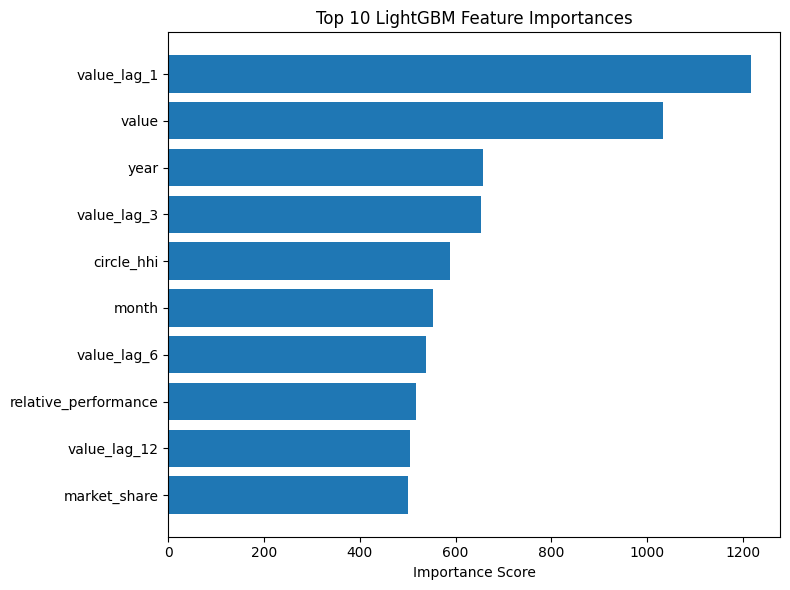


📈 SHAP Summary Plot (Global Feature Impact):


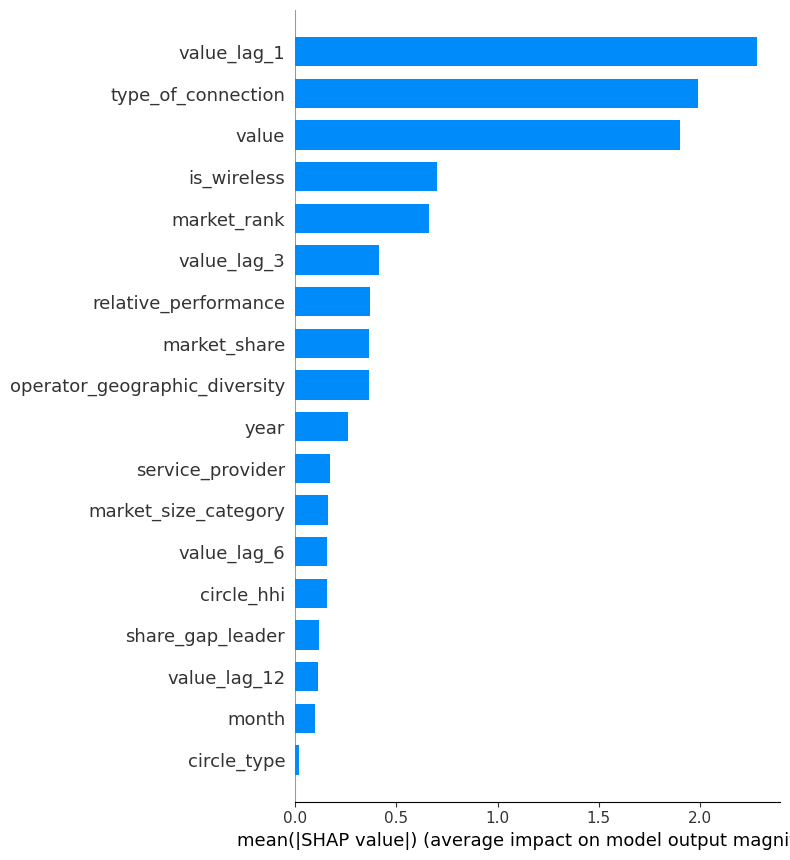

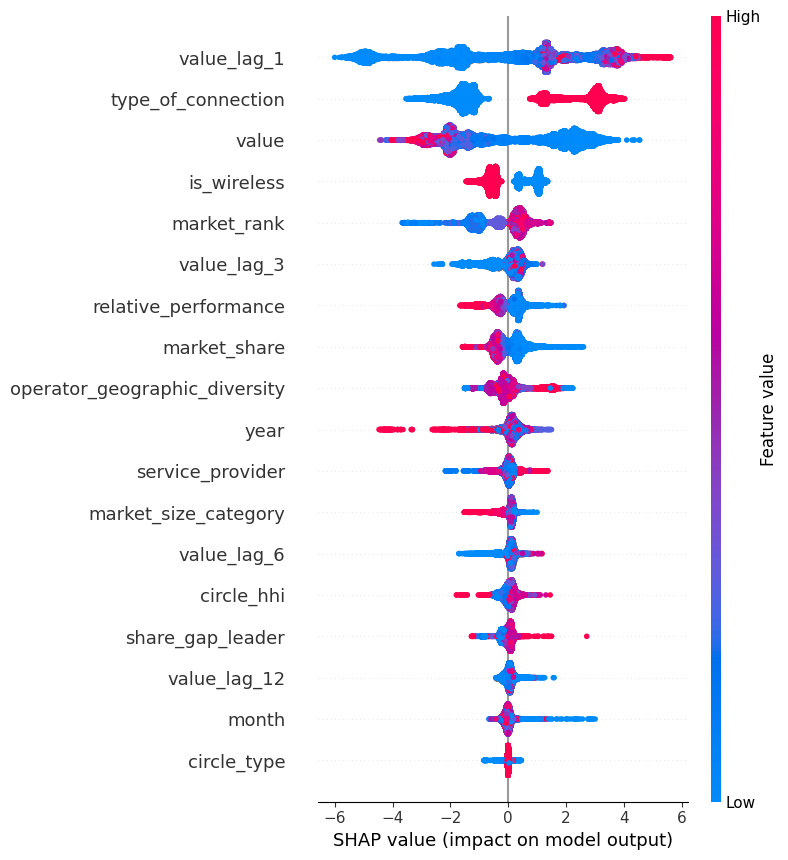


🔍 Local Explanation for Sample Index: 28467
Feature values:
  year  month  type_of_connection  service_provider      value  value_lag_1  value_lag_3  value_lag_6  value_lag_12  circle_type  is_wireless  operator_geographic_diversity  market_size_category  market_share  market_rank  share_gap_leader  relative_performance  circle_hhi
 2018      6                   0                22 14079350.0    7145626.0   43944459.0   36104213.0    13197839.0            1            1                             25              0.805556      0.381754          2.0          0.044333              2.290523    0.355658



💬 Plain Language Explanation:
- The model predicts churn **unlikely** for this customer.
- Features pushing the prediction **up (toward churn)**: value_lag_1, circle_hhi, value_lag_3.
- Features pushing the prediction **down (retention)**: market_rank, type_of_connection, value.


In [ ]:
# ===============================================================
# 🌟 LightGBM Feature Importance & SHAP Explainability
# ===============================================================
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Train final LightGBM model on all data ----
final_lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)
final_lgb.fit(X, y)

# ---- Feature Importance ----
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_lgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 📊 Display Top 10 Important Features
top10_features = feature_importance.head(10)
print("\n🏆 Top 10 Most Important Features:")
print(top10_features.to_string(index=False))

# ---- Plot Feature Importance ----
plt.figure(figsize=(8, 6))
plt.barh(top10_features['Feature'][::-1], top10_features['Importance'][::-1])
plt.title("Top 10 LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# ---- SHAP Explainability ----
explainer = shap.TreeExplainer(final_lgb)
shap_values = explainer.shap_values(X)

# Global Feature Importance (SHAP Summary)
print("\n📈 SHAP Summary Plot (Global Feature Impact):")
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed SHAP Summary (Bee Swarm)
shap.summary_plot(shap_values, X)

# ---- Local Explainability Example ----
# Pick one random observation to explain
sample_index = np.random.randint(0, X.shape[0])
sample = X.iloc[[sample_index]]

print(f"\n🔍 Local Explanation for Sample Index: {sample_index}")
print("Feature values:\n", sample.to_string(index=False))

# Calculate SHAP values for the single instance
shap_local = explainer.shap_values(sample)

# Visualize individual force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_local, sample)

# ---- Plain Language Explanation ----
# Get top positive and negative impact features
shap_values_df = pd.DataFrame({
    'Feature': sample.columns,
    'SHAP Value': shap_local[0]
}).sort_values(by='SHAP Value', ascending=False)

top_positive = shap_values_df.head(3)
top_negative = shap_values_df.tail(3)

print("\n💬 Plain Language Explanation:")
print(f"- The model predicts churn **{('likely' if y.iloc[sample_index]==1 else 'unlikely')}** for this customer.")
print(f"- Features pushing the prediction **up (toward churn)**: {', '.join(top_positive['Feature'].values)}.")
print(f"- Features pushing the prediction **down (retention)**: {', '.join(top_negative['Feature'].values)}.")

## BREAK